<a href="https://colab.research.google.com/github/jieun0441/XMC/blob/main/Figure_3_light_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#@title 인덱스엇갈림 현상 확인

import os
import numpy as np
import pandas as pd

data_dir = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public"

# 1. 공통 데이터 로드
df_pop = pd.read_excel(os.path.join(data_dir, "population_Seoul_426dong_2023.xlsx"), sheet_name="Sheet1", engine="openpyxl")
df_pop["dong_cd"] = df_pop["dong_cd"].astype(str)

df_T_w = pd.read_excel(os.path.join(data_dir, "Tij_P1_Going_to_Work_in2023.xlsx"), usecols=["O_ADMDONG_CD", "D_ADMDONG_CD", "CNT"], engine="openpyxl")
df_T_w["O_ADMDONG_CD"] = df_T_w["O_ADMDONG_CD"].astype(str).str.replace('.0', '', regex=False)
df_T_w["D_ADMDONG_CD"] = df_T_w["D_ADMDONG_CD"].astype(str).str.replace('.0', '', regex=False)


print("="*60)
print(" 1. 기존 코드 방식 (Cell 2 vs Cell 4 불일치 확인)")
print("="*60)
# 기존 Cell 2 방식 (거리용 인덱스)
dong_ids_cell2 = df_pop["dong_cd"].tolist()
# 기존 Cell 4 방식 (통행용 인덱스)
dong_ids_cell4 = sorted(set(df_T_w["O_ADMDONG_CD"]) | set(df_T_w["D_ADMDONG_CD"]))

print(f"거리용 기준 동(Dong) 갯수: {len(dong_ids_cell2)}개")
print(f"통행용 기준 동(Dong) 갯수: {len(dong_ids_cell4)}개")
print("\n[인덱스 0~4번 매칭 비교]")
for i in range(5):
    print(f" Index {i}: (거리 매트릭스) {dong_ids_cell2[i]}  <--->  (통행 매트릭스) {dong_ids_cell4[i]}")
print(" >> 결과: 코드가 서로 다름! (기존 시뮬레이션에서 엉뚱한 동끼리 거리가 계산됨)")


print("\n\n" + "="*60)
print(" 2. 통합된 코드 방식 (동일한 인덱스로 매칭)")
print("="*60)
id_to_idx = {d: i for i, d in enumerate(dong_ids_cell2)}
n = len(dong_ids_cell2)

T_w_new = np.zeros((n, n), dtype=float)
for _, row in df_T_w.iterrows():
    i, j = id_to_idx.get(row["O_ADMDONG_CD"]), id_to_idx.get(row["D_ADMDONG_CD"])
    if i is not None and j is not None:
        T_w_new[i, j] = pd.to_numeric(row["CNT"], errors="coerce")

# 기존 방식 매트릭스 생성 시뮬레이션 (Cell 4 로직)
id_to_idx_old = {d: i for i, d in enumerate(dong_ids_cell4)}
n_old = len(dong_ids_cell4)
T_w_old = np.zeros((n_old, n_old), dtype=float)
for _, row in df_T_w.iterrows():
    i, j = id_to_idx_old.get(row["O_ADMDONG_CD"]), id_to_idx_old.get(row["D_ADMDONG_CD"])
    if i is not None and j is not None:
        T_w_old[i, j] = pd.to_numeric(row["CNT"], errors="coerce")

print(f"새로운 매트릭스(T_w) 내 총 통행량(Sum): {T_w_new.sum():,.0f}건")
print(f"기존 매트릭스(T_w) 내 총 통행량(Sum): {T_w_old.sum():,.0f}건")
print(" >> 결과: 포함된 통행 데이터의 총량은 100% 동일함! 누락 없음.")
print("="*60)

 1. 기존 코드 방식 (Cell 2 vs Cell 4 불일치 확인)
거리용 기준 동(Dong) 갯수: 426개
통행용 기준 동(Dong) 갯수: 426개

[인덱스 0~4번 매칭 비교]
 Index 0: (거리 매트릭스) 11110530  <--->  (통행 매트릭스) 11110515
 Index 1: (거리 매트릭스) 11110540  <--->  (통행 매트릭스) 11110530
 Index 2: (거리 매트릭스) 11110550  <--->  (통행 매트릭스) 11110540
 Index 3: (거리 매트릭스) 11110560  <--->  (통행 매트릭스) 11110550
 Index 4: (거리 매트릭스) 11110570  <--->  (통행 매트릭스) 11110560
 >> 결과: 코드가 서로 다름! (기존 시뮬레이션에서 엉뚱한 동끼리 거리가 계산됨)


 2. 통합된 코드 방식 (동일한 인덱스로 매칭)
새로운 매트릭스(T_w) 내 총 통행량(Sum): 693,286,014건
기존 매트릭스(T_w) 내 총 통행량(Sum): 693,286,014건
 >> 결과: 포함된 통행 데이터의 총량은 100% 동일함! 누락 없음.


In [3]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import FuncFormatter

# ==========================================
# 0. Colab 환경에 Arial 폰트 완벽 적용
# ==========================================
print(">> Downloading and setting Arial font...")
font_url = "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"
font_path = "Arial.ttf"
if not os.path.exists(font_path):
    urllib.request.urlretrieve(font_url, font_path)

fm.fontManager.addfont(font_path)
arial_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = arial_prop.get_name()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.default'] = 'regular'

# ==========================================
# 1. 데이터 로드 및 초기 설정 (ID 매칭 완벽 처리)
# ==========================================
data_dir = "/content/drive/MyDrive/FMC_Data/Sharing_to_Public"

# [핵심 수정] 행정동 코드(ID) 뒤에 붙는 '.0'을 제거하여 완벽하게 매칭시키는 함수
def clean_id(x):
    s = str(x).strip()
    if s.endswith('.0'):
        return s[:-2]
    return s

print(">> Loading and processing data...")
# 인구 데이터 (Weights)
df_pop = pd.read_excel(os.path.join(data_dir, "population_Seoul_426dong_2023.xlsx"), sheet_name="Sheet1", engine="openpyxl")
df_pop["dong_cd"] = df_pop["dong_cd"].apply(clean_id) # 클렌징 적용
dong_ids = df_pop["dong_cd"].tolist()
weights_pop = df_pop.set_index("dong_cd").loc[dong_ids, "defacto_pop"].astype(float).fillna(0.0).clip(lower=0.0).to_numpy()
Pj_pop = weights_pop

# 거리 행렬
df_dist_radius = pd.read_csv(os.path.join(data_dir, "Distance_Matrix_dong_to_dong_in_Seoul_MBData_code_system_if_same_filled_radius_assuming_circle.csv"), dtype={"O_ADMDONG_CD": str, "D_ADMDONG_CD": str})
id_to_idx = {d: i for i, d in enumerate(dong_ids)}
n = len(dong_ids)
D = np.full((n, n), np.nan, dtype=float)
for _, row in df_dist_radius.iterrows():
    i, j = id_to_idx.get(clean_id(row["O_ADMDONG_CD"])), id_to_idx.get(clean_id(row["D_ADMDONG_CD"]))
    if i is not None and j is not None:
        D[i, j] = float(row["Distance"])
D_pos = np.maximum(D, 1e-12)

# 통행 데이터
usecols_t = ["O_ADMDONG_CD", "D_ADMDONG_CD", "CNT"]
df_T_nw = pd.read_excel(os.path.join(data_dir, "Tij_NonworkTrips_P24567_in2023.xlsx"), usecols=usecols_t, engine="openpyxl")
df_T_w  = pd.read_excel(os.path.join(data_dir, "Tij_P1_Going_to_Work_in2023.xlsx"), usecols=usecols_t, engine="openpyxl")

T_nw, T_w = np.zeros((n, n), dtype=float), np.zeros((n, n), dtype=float)
for df_T, T_mat in [(df_T_nw, T_nw), (df_T_w, T_w)]:
    for _, row in df_T.iterrows():
        i, j = id_to_idx.get(clean_id(row["O_ADMDONG_CD"])), id_to_idx.get(clean_id(row["D_ADMDONG_CD"]))
        if i is not None and j is not None:
            T_mat[i, j] = pd.to_numeric(row["CNT"], errors="coerce")

# ==========================================
# 2. 핵심 함수 정의 (모델 시뮬레이션 및 KS)
# ==========================================
def build_P_modelC(D_pos, gamma):
    with np.errstate(divide='ignore', invalid='ignore'): W = np.power(D_pos, -gamma, dtype=float)
    W[(~np.isfinite(W)) | (W < 0)] = 0.0
    P = np.zeros_like(W, dtype=float)
    for i in range(W.shape[0]):
        s = W[i].sum()
        P[i, :] = (W[i] / s) if s > 0 else (np.ones(W.shape[1]) / W.shape[1])
    return P

def build_P_modelD(D_pos, gamma, Pj):
    with np.errstate(divide='ignore', invalid='ignore'): W0 = np.power(D_pos, -gamma, dtype=float)
    W0[(~np.isfinite(W0)) | (W0 < 0)] = 0.0
    w_mat = W0 * Pj
    P = np.zeros_like(W0, dtype=float)
    for i in range(W0.shape[0]):
        s = w_mat[i].sum()
        P[i, :] = (w_mat[i] / s) if s > 0 else (np.ones(W0.shape[1]) / W0.shape[1])
    return P

def simulate_from_OT(OT_vec, P_mat, rng):
    n = len(OT_vec)
    T_sim = np.zeros((n, n), dtype=float)
    for i in range(n):
        n_i = int(np.rint(float(OT_vec[i])))
        if n_i > 0: T_sim[i, :] = rng.multinomial(n_i, P_mat[i], size=1)[0]
    return T_sim

def compute_PE(T):
    total = T.sum()
    IT = T.sum(axis=0)
    with np.errstate(divide="ignore", invalid="ignore"):
        return np.where(total > 0, IT / total, 0.0)

def mean_SC_PE_empOT(T_emp, P_mat, N_sims=100, seed=42):
    rng = np.random.default_rng(seed)
    OT_emp = T_emp.sum(axis=1)
    SC_sims, PE_sims = np.zeros((N_sims, T_emp.shape[0])), np.zeros((N_sims, T_emp.shape[0]))
    for s_idx in range(N_sims):
        T_sim = simulate_from_OT(OT_emp, P_mat, rng)
        OT = T_sim.sum(axis=1)
        diag = np.diag(T_sim)
        SC = np.zeros_like(OT, dtype=float)
        m = OT > 0
        SC[m] = diag[m] / OT[m]
        SC_sims[s_idx, :] = SC
        PE_sims[s_idx, :] = compute_PE(T_sim)
    return SC_sims.mean(axis=0), PE_sims.mean(axis=0)

def ks_distance_weighted(a, b, w_a, w_b):
    a, b, w_a, w_b = map(lambda x: np.asarray(x, float), (a, b, w_a, w_b))
    ma = np.isfinite(a) & np.isfinite(w_a) & (w_a >= 0)
    mb = np.isfinite(b) & np.isfinite(w_b) & (w_b >= 0)
    a, w_a = a[ma], w_a[ma]
    b, w_b = b[mb], w_b[mb]
    sa, sb = w_a.sum(), w_b.sum()
    if sa <= 0 or sb <= 0 or a.size < 2 or b.size < 2: return np.inf
    w_a, w_b = w_a / sa, w_b / sb
    ia, ib = np.argsort(a), np.argsort(b)
    a_s, wa_s, b_s, wb_s = a[ia], w_a[ia], b[ib], w_b[ib]
    xs = np.unique(np.concatenate([a_s, b_s]))
    cdfa = np.interp(xs, a_s, np.cumsum(wa_s), left=0, right=1)
    cdfb = np.interp(xs, b_s, np.cumsum(wb_s), left=0, right=1)
    return float(np.max(np.abs(cdfa - cdfb)))

def SC_share_from(T):
    OT, diag = T.sum(axis=1), np.diag(T)
    SC = np.zeros_like(OT, dtype=float)
    m = OT > 0
    SC[m] = diag[m] / OT[m]
    return SC

# ==========================================
# 3. 최적 Gamma 찾기 (KS-weighted)
# ==========================================
N_SIMS = 100
GAMMA_GRID = np.linspace(0.2, 3.0, 60)

targets = {
    "nw": {"SC": SC_share_from(T_nw), "PE": compute_PE(T_nw)},
    "w" : {"SC": SC_share_from(T_w),  "PE": compute_PE(T_w)}
}
datasets = {"nw": T_nw, "w": T_w}

best_params = {k: {"C": {"gamma": np.nan, "KS": np.inf}, "D": {"gamma": np.nan, "KS": np.inf}}
               for k in ["SC_nw", "SC_w", "PE_nw", "PE_w"]}

print(">> Optimizing Gamma (This may take a minute)...")
for label in ["nw", "w"]:
    T_emp = datasets[label]
    for g in GAMMA_GRID:
        P_C, P_D = build_P_modelC(D_pos, g), build_P_modelD(D_pos, g, Pj_pop)
        SC_C, PE_C = mean_SC_PE_empOT(T_emp, P_C, N_sims=N_SIMS)
        SC_D, PE_D = mean_SC_PE_empOT(T_emp, P_D, N_sims=N_SIMS)

        for q, emp_C, emp_D in [("SC", SC_C, SC_D), ("PE", PE_C, PE_D)]:
            key = f"{q}_{label}"
            ksC = ks_distance_weighted(targets[label][q], emp_C, weights_pop, weights_pop)
            ksD = ks_distance_weighted(targets[label][q], emp_D, weights_pop, weights_pop)
            if ksC < best_params[key]["C"]["KS"]: best_params[key]["C"] = {"gamma": g, "KS": ksC}
            if ksD < best_params[key]["D"]["KS"]: best_params[key]["D"] = {"gamma": g, "KS": ksD}


>> Downloading and setting Arial font...
>> Loading and processing data...
>> Optimizing Gamma (This may take a minute)...


>> Downloading and setting Arial font...
>> Loading and processing data...
>> Optimizing Gamma (This may take a minute)...
>> Plotting Figure 3...

>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Figure3_Combined_180mm.pdf
>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Figure3_Combined_180mm.jpg


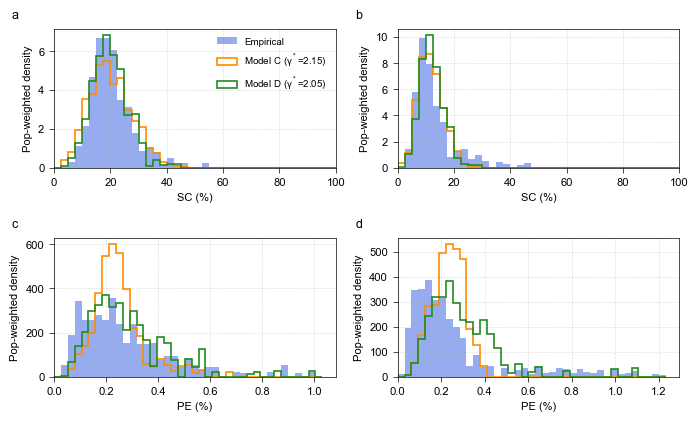

In [5]:

# ==========================================
# 4. Figure 3 렌더링 (180mm 2x2 패널 + 100배 스케일링 축)
# ==========================================
def _SC_PE_from_gamma(label, gamma, model="C"):
    T_emp = datasets[label]
    P = build_P_modelC(D_pos, gamma) if model == "C" else build_P_modelD(D_pos, gamma, Pj_pop)
    return mean_SC_PE_empOT(T_emp, P, N_sims=N_SIMS)

print(">> Plotting Figure 3...")
# 180mm = 7.08 inches
fig_width = 180 / 25.4
fig_height = 110 / 25.4 # 높이 조절
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# 포맷터 정의 (%로 표시하기 위해 100 곱하기)
def format_pct_SC(x, pos): return f"{x * 100:.0f}"  # 0, 20, 40...
def format_pct_PE(x, pos): return f"{x * 100:.1f}"  # 0.0, 0.4, 0.8...

panels = [
    (axs[0,0], "nw", "SC", "a", "SC nw (Non-work)"),
    (axs[0,1], "w",  "SC", "b", "SC w (Work)"),
    (axs[1,0], "nw", "PE", "c", "PE nw (Non-work)"),
    (axs[1,1], "w",  "PE", "d", "PE w (Work)")
]

for ax, label, quantity, p_label, title in panels:
    x_emp = targets[label][quantity]
    gC, gD = best_params[f"{quantity}_{label}"]["C"]["gamma"], best_params[f"{quantity}_{label}"]["D"]["gamma"]

    val_C, val_D = _SC_PE_from_gamma(label, gC, model="C"), _SC_PE_from_gamma(label, gD, model="D")
    xC = val_C[0] if quantity == "SC" else val_C[1]
    xD = val_D[0] if quantity == "SC" else val_D[1]

    valid = np.isfinite(x_emp) & np.isfinite(weights_pop) & (weights_pop >= 0)
    w = weights_pop[valid]

    # Bins 설정 및 에러 방지
    if quantity == "SC":
        bins = np.linspace(0.0, 1.0, 41)
        ax.set_xlabel('SC (%)', fontsize=8)
        ax.xaxis.set_major_formatter(FuncFormatter(format_pct_SC))
        ax.set_xlim(0, 1.0)
        ax.set_xticks(np.arange(0, 1.01, 0.2)) # 0, 0.2, 0.4, 0.6, 0.8, 1.0
    else:
        all_vals = np.concatenate([x_emp[valid], xC[valid], xD[valid]])
        xmax = np.percentile(all_vals, 99.5) if all_vals.size else 0.01
        if xmax <= 0: xmax = 0.01 # 안전장치
        bins = np.linspace(0.0, float(xmax), 40)
        ax.set_xlabel('PE (%)', fontsize=8)
        ax.xaxis.set_major_formatter(FuncFormatter(format_pct_PE))
        ax.set_xlim(0, float(xmax * 1.05))

    # [수정] SyntaxWarning 해결을 위해 r 문자열(raw string) 사용 (rf"...")
    ax.hist(x_emp[valid], bins=bins, density=True, weights=w, alpha=0.55, color='royalblue', label="Empirical")
    ax.hist(xC[valid], bins=bins, density=True, weights=w, histtype='step', linewidth=1.2, color='darkorange', label=rf"Model C ($\gamma^*$={gC:.2f})")
    ax.hist(xD[valid], bins=bins, density=True, weights=w, histtype='step', linewidth=1.2, color='forestgreen', label=rf"Model D ($\gamma^*$={gD:.2f})")

    ax.set_ylabel("Pop-weighted density", fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=8, width=0.5)
    ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.5)

    # 테두리 두께 얇게
    for spine in ax.spines.values(): spine.set_linewidth(0.5)

    # 패널 번호 (a, b, c, d)
    ax.text(-0.15, 1.05, p_label, transform=ax.transAxes, fontsize=9, fontweight='bold', va='bottom', ha='left')

    if p_label == "a": # 범례는 첫 번째 패널에만 깔끔하게 표시
        legend = ax.legend(loc='upper right', fontsize=7, frameon=False)

plt.tight_layout()

# 저장
PDF_DIR = "/content/drive/MyDrive/FMC_Data/Combined_Figure/"
os.makedirs(PDF_DIR, exist_ok=True)
save_path_pdf = os.path.join(PDF_DIR, "Figure3_Combined_180mm.pdf")
save_path_jpg = os.path.join(PDF_DIR, "Figure3_Combined_180mm.jpg")
plt.savefig(save_path_pdf, bbox_inches="tight")
plt.savefig(save_path_jpg, dpi=300, bbox_inches="tight")
print(f"\n>> [Saved] {save_path_pdf}")
print(f">> [Saved] {save_path_jpg}")

plt.show()

>> Downloading and setting Arial font...
>> Plotting Figure 3 (Vibrant Colors & Compact Legends)...

>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Figure3_Combined_Final.pdf
>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Figure3_Combined_Final.jpg


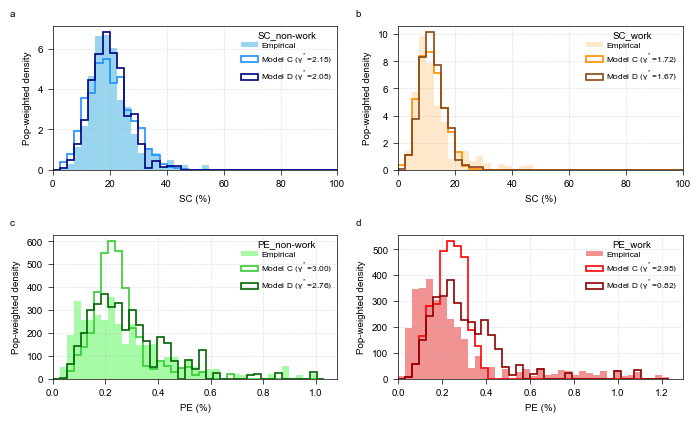

In [7]:
import os
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import FuncFormatter

# ==========================================
# 0. Colab 환경에 Arial 폰트 완벽 적용
# ==========================================
print(">> Downloading and setting Arial font...")
font_url = "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"
font_path = "Arial.ttf"
if not os.path.exists(font_path):
    urllib.request.urlretrieve(font_url, font_path)

fm.fontManager.addfont(font_path)
arial_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = arial_prop.get_name()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['mathtext.default'] = 'regular'

# ==========================================
# 1~3단계: 데이터 로드 및 최적 Gamma 계산
# (기존에 메모리에 targets, datasets, best_params, Pj_pop 등이 모두 있다고 가정)
# ==========================================


>> Plotting Figure 3 (Refined Lines, Colors & Legends)...

>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Figure3_Combined_Final.pdf
>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Figure3_Combined_Final.jpg


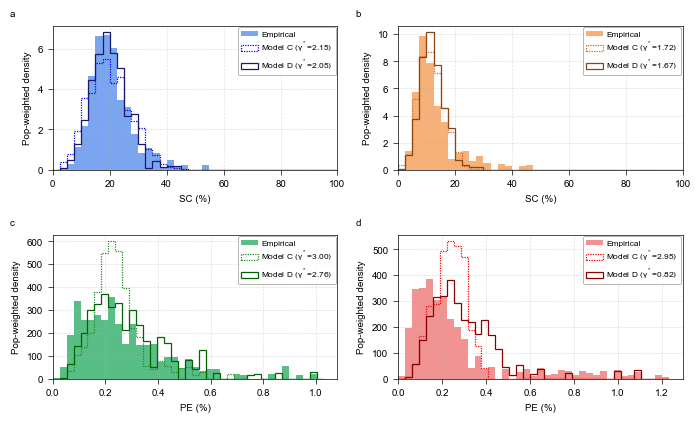

In [14]:
# ==========================================
#@title 4. Figure 3
# ==========================================
def _SC_PE_from_gamma(label, gamma, model="C"):
    T_emp = datasets[label]
    P = build_P_modelC(D_pos, gamma) if model == "C" else build_P_modelD(D_pos, gamma, Pj_pop)
    return mean_SC_PE_empOT(T_emp, P, N_sims=N_SIMS)

print(">> Plotting Figure 3 (Refined Lines, Colors & Legends)...")

color_themes = {
    'SC_nw': {'emp': 'cornflowerblue', 'C': 'blue',        'D': 'midnightblue'},
    'SC_w':  {'emp': 'sandybrown',     'C': 'chocolate',   'D': 'saddlebrown'},
    'PE_nw': {'emp': 'mediumseagreen', 'C': 'forestgreen', 'D': 'darkgreen'},
    'PE_w':  {'emp': 'lightcoral',     'C': 'red',         'D': 'darkred'}
}

# 180mm = 7.08 inches
fig_width = 180 / 25.4
fig_height = 110 / 25.4
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

def format_pct_SC(x, pos): return f"{x * 100:.0f}"
def format_pct_PE(x, pos): return f"{x * 100:.1f}"

panels = [
    (axs[0,0], "nw", "SC", "a"),
    (axs[0,1], "w",  "SC", "b"),
    (axs[1,0], "nw", "PE", "c"),
    (axs[1,1], "w",  "PE", "d")
]

MAX_FONT = 7
LEGEND_FONT = 6

for ax, label, quantity, p_label in panels:
    x_emp = targets[label][quantity]
    gC, gD = best_params[f"{quantity}_{label}"]["C"]["gamma"], best_params[f"{quantity}_{label}"]["D"]["gamma"]

    val_C, val_D = _SC_PE_from_gamma(label, gC, model="C"), _SC_PE_from_gamma(label, gD, model="D")
    xC = val_C[0] if quantity == "SC" else val_C[1]
    xD = val_D[0] if quantity == "SC" else val_D[1]

    valid = np.isfinite(x_emp) & np.isfinite(weights_pop) & (weights_pop >= 0)
    w = weights_pop[valid]
    theme = color_themes[f"{quantity}_{label}"]

    if quantity == "SC":
        bins = np.linspace(0.0, 1.0, 41)
        ax.set_xlabel('SC (%)', fontsize=MAX_FONT)
        ax.xaxis.set_major_formatter(FuncFormatter(format_pct_SC))
        ax.set_xlim(0, 1.0)
        ax.set_xticks(np.arange(0, 1.01, 0.2))
    else:
        all_vals = np.concatenate([x_emp[valid], xC[valid], xD[valid]])
        xmax = np.percentile(all_vals, 99.5) if all_vals.size else 0.01
        if xmax <= 0: xmax = 0.01
        bins = np.linspace(0.0, float(xmax), 40)
        ax.set_xlabel('PE (%)', fontsize=MAX_FONT)
        ax.xaxis.set_major_formatter(FuncFormatter(format_pct_PE))
        ax.set_xlim(0, float(xmax * 1.05))

    # 1. Empirical 베이스 색상
    ax.hist(x_emp[valid], bins=bins, density=True, weights=w, alpha=0.85, color=theme['emp'], label="Empirical")

    # 2. [에러 우회] Model C - 기본 선으로 먼저 그리고 -> 커스텀 점선 덧씌우기
    _, _, patches_C = ax.hist(xC[valid], bins=bins, density=True, weights=w, histtype='step',
                              linewidth=0.9, color=theme['C'], label=rf"Model C ($\gamma^*$={gC:.2f})")
    patches_C[0].set_linestyle((0, (1.0, 1.0))) # 여기서 촘촘한 점선 강제 적용!

    # 3. Model D - 실선
    ax.hist(xD[valid], bins=bins, density=True, weights=w, histtype='step',
            linewidth=0.9, linestyle='-', color=theme['D'], label=rf"Model D ($\gamma^*$={gD:.2f})")

    ax.set_ylabel("Pop-weighted density", fontsize=MAX_FONT)
    ax.tick_params(axis='both', which='major', labelsize=MAX_FONT, width=0.5)
    ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.5)

    for spine in ax.spines.values(): spine.set_linewidth(0.5)

    ax.text(-0.15, 1.05, p_label, transform=ax.transAxes, fontsize=MAX_FONT, fontweight='bold', va='bottom', ha='left')

    legend = ax.legend(loc='upper right',
                       fontsize=LEGEND_FONT,
                       frameon=True,
                       labelspacing=0.25,
                       handletextpad=0.4,
                       borderaxespad=0.2)

    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_edgecolor('grey') # legend outline color

plt.tight_layout()

# 저장
PDF_DIR = "/content/drive/MyDrive/FMC_Data/Combined_Figure/"
os.makedirs(PDF_DIR, exist_ok=True)
save_path_pdf = os.path.join(PDF_DIR, "Figure3_Combined_Final.pdf")
save_path_jpg = os.path.join(PDF_DIR, "Figure3_Combined_Final.jpg")
plt.savefig(save_path_pdf, bbox_inches="tight")
plt.savefig(save_path_jpg, dpi=300, bbox_inches="tight")
print(f"\n>> [Saved] {save_path_pdf}")
print(f">> [Saved] {save_path_jpg}")

plt.show()


>> [Supplementary] Scanning Gamma to plot KS-distance traces...
>> Plotting Supplementary Figure (KS vs Gamma)...

>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Supp_Figure_KS_Trace_Fixed.pdf
>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Supp_Figure_KS_Trace_Fixed.jpg


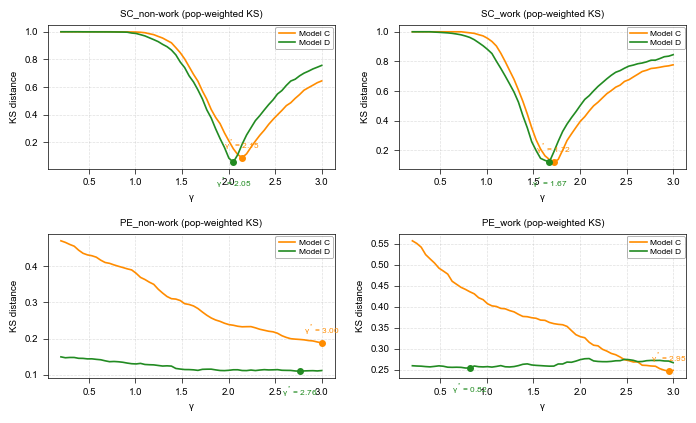

In [6]:
# ============================================================
# Supplementary Figure: SC & PE KS-distance Trace (γ-scan)
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt

print("\n>> [Supplementary] Scanning Gamma to plot KS-distance traces...")

# 1. Traces 저장을 위한 딕셔너리 초기화
ks_traces = {
    "SC_nw": {"C": np.zeros(len(GAMMA_GRID)), "D": np.zeros(len(GAMMA_GRID))},
    "SC_w":  {"C": np.zeros(len(GAMMA_GRID)), "D": np.zeros(len(GAMMA_GRID))},
    "PE_nw": {"C": np.zeros(len(GAMMA_GRID)), "D": np.zeros(len(GAMMA_GRID))},
    "PE_w":  {"C": np.zeros(len(GAMMA_GRID)), "D": np.zeros(len(GAMMA_GRID))}
}

# 2. Gamma 스캔 및 KS 계산
for label in ["nw", "w"]:
    T_emp = datasets[label]
    for gi, g in enumerate(GAMMA_GRID):
        P_C = build_P_modelC(D_pos, g)
        P_D = build_P_modelD(D_pos, g, Pj_pop)

        SC_C, PE_C = mean_SC_PE_empOT(T_emp, P_C, N_sims=N_SIMS)
        SC_D, PE_D = mean_SC_PE_empOT(T_emp, P_D, N_sims=N_SIMS)

        ks_traces[f"SC_{label}"]["C"][gi] = ks_distance_weighted(targets[label]["SC"], SC_C, weights_pop, weights_pop)
        ks_traces[f"SC_{label}"]["D"][gi] = ks_distance_weighted(targets[label]["SC"], SC_D, weights_pop, weights_pop)

        ks_traces[f"PE_{label}"]["C"][gi] = ks_distance_weighted(targets[label]["PE"], PE_C, weights_pop, weights_pop)
        ks_traces[f"PE_{label}"]["D"][gi] = ks_distance_weighted(targets[label]["PE"], PE_D, weights_pop, weights_pop)

print(">> Plotting Supplementary Figure (KS vs Gamma)...")

# 3. 180mm 너비에 맞춘 2x2 패널 시각화
fig_width = 180 / 25.4
fig_height = 110 / 25.4
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

panels_ks = [
    (axs[0,0], "SC_nw", "SC_non-work (pop-weighted KS)"),
    (axs[0,1], "SC_w",  "SC_work (pop-weighted KS)"),
    (axs[1,0], "PE_nw", "PE_non-work (pop-weighted KS)"),
    (axs[1,1], "PE_w",  "PE_work (pop-weighted KS)")
]

MAX_FONT = 7
LEGEND_FONT = 6

for ax, key, title in panels_ks:
    ksC = ks_traces[key]["C"]
    ksD = ks_traces[key]["D"]

    ax.plot(GAMMA_GRID, ksC, lw=1.2, color='darkorange', label="Model C")
    ax.plot(GAMMA_GRID, ksD, lw=1.2, color='forestgreen', label="Model D")

    if np.any(np.isfinite(ksC)):
        iC = int(np.nanargmin(ksC))
        ax.plot(GAMMA_GRID[iC], ksC[iC], 'o', color='darkorange', markersize=4)
        ax.annotate(rf"$\gamma^*={GAMMA_GRID[iC]:.2f}$",
                    (GAMMA_GRID[iC], ksC[iC]),
                    textcoords="offset points", xytext=(0, 6), ha='center', fontsize=LEGEND_FONT, color='darkorange')

    if np.any(np.isfinite(ksD)):
        iD = int(np.nanargmin(ksD))
        ax.plot(GAMMA_GRID[iD], ksD[iD], 'o', color='forestgreen', markersize=4)
        ax.annotate(rf"$\gamma^*={GAMMA_GRID[iD]:.2f}$",
                    (GAMMA_GRID[iD], ksD[iD]),
                    textcoords="offset points", xytext=(0, -10), ha='center', va='top', fontsize=LEGEND_FONT, color='forestgreen')

    ax.set_title(title, fontsize=MAX_FONT, fontweight='bold')
    ax.set_xlabel(r"$\gamma$", fontsize=MAX_FONT)
    ax.set_ylabel("KS distance", fontsize=MAX_FONT)
    ax.tick_params(axis='both', which='major', labelsize=MAX_FONT, width=0.5)
    ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.5)
    for spine in ax.spines.values(): spine.set_linewidth(0.5)

    legend = ax.legend(loc='upper right', fontsize=LEGEND_FONT, frameon=True,
                       labelspacing=0.25, handletextpad=0.4, borderaxespad=0.2)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_edgecolor('#808080')

plt.tight_layout()

# 4. 저장 (경로 추가)
PDF_DIR = "/content/drive/MyDrive/FMC_Data/Combined_Figure/"
os.makedirs(PDF_DIR, exist_ok=True)

save_path_pdf_ks = os.path.join(PDF_DIR, "Supp_Figure_KS_Trace_Fixed.pdf")
save_path_jpg_ks = os.path.join(PDF_DIR, "Supp_Figure_KS_Trace_Fixed.jpg")
plt.savefig(save_path_pdf_ks, bbox_inches="tight")
plt.savefig(save_path_jpg_ks, dpi=300, bbox_inches="tight")

print(f"\n>> [Saved] {save_path_pdf_ks}")
print(f">> [Saved] {save_path_jpg_ks}")

plt.show()


>> [Supplementary] Scanning Gamma to plot KS-distance traces...
>> Plotting Supplementary Figure (Final Refined formatting)...

>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Supp_Figure_KS_Trace_Fixed.pdf
>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Supp_Figure_KS_Trace_Fixed.jpg


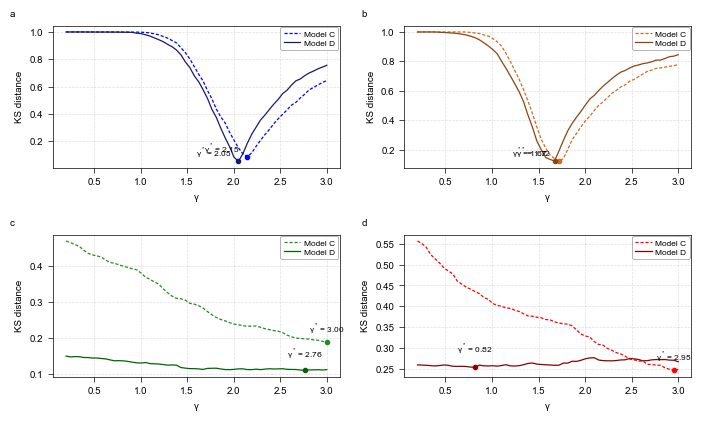

In [8]:
# ============================================================
# Supplementary Figure: SC & PE KS-distance Trace (γ-scan)
# [Final Refined: Max 7pt Font, Matching Colors & Non-overlapping Labels]
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt

print("\n>> [Supplementary] Scanning Gamma to plot KS-distance traces...")

# (가정: GAMMA_GRID, best_params, targets, datasets 등은 이미 메모리에 있음)

# [추가] Figure 3와 완벽하게 동일한 색상 테마 명시적 정의
color_themes = {
    'SC_nw': {'C': 'blue',        'D': 'midnightblue'},
    'SC_w':  {'C': 'chocolate',   'D': 'saddlebrown'},
    'PE_nw': {'C': 'forestgreen', 'D': 'darkgreen'},
    'PE_w':  {'C': 'red',         'D': 'darkred'}
}

# 1. Traces 저장을 위한 딕셔너리 초기화
ks_traces = {
    "SC_nw": {"C": np.zeros(len(GAMMA_GRID)), "D": np.zeros(len(GAMMA_GRID))},
    "SC_w":  {"C": np.zeros(len(GAMMA_GRID)), "D": np.zeros(len(GAMMA_GRID))},
    "PE_nw": {"C": np.zeros(len(GAMMA_GRID)), "D": np.zeros(len(GAMMA_GRID))},
    "PE_w":  {"C": np.zeros(len(GAMMA_GRID)), "D": np.zeros(len(GAMMA_GRID))}
}

# 2. Gamma 스캔 및 KS 계산
for label in ["nw", "w"]:
    T_emp = datasets[label]
    for gi, g in enumerate(GAMMA_GRID):
        P_C = build_P_modelC(D_pos, g)
        P_D = build_P_modelD(D_pos, g, Pj_pop)

        SC_C, PE_C = mean_SC_PE_empOT(T_emp, P_C, N_sims=N_SIMS)
        SC_D, PE_D = mean_SC_PE_empOT(T_emp, P_D, N_sims=N_SIMS)

        ks_traces[f"SC_{label}"]["C"][gi] = ks_distance_weighted(targets[label]["SC"], SC_C, weights_pop, weights_pop)
        ks_traces[f"SC_{label}"]["D"][gi] = ks_distance_weighted(targets[label]["SC"], SC_D, weights_pop, weights_pop)

        ks_traces[f"PE_{label}"]["C"][gi] = ks_distance_weighted(targets[label]["PE"], PE_C, weights_pop, weights_pop)
        ks_traces[f"PE_{label}"]["D"][gi] = ks_distance_weighted(targets[label]["PE"], PE_D, weights_pop, weights_pop)

print(">> Plotting Supplementary Figure (Final Refined formatting)...")

# 180mm = 7.08 inches
fig_width = 180 / 25.4
fig_height = 110 / 25.4
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

# 폰트 크기 완벽 통일 (최대 7pt)
MAX_FONT = 7
LEGEND_FONT = 6

panels_ks = [
    (axs[0,0], "SC_nw", "a"),
    (axs[0,1], "SC_w",  "b"),
    (axs[1,0], "PE_nw", "c"),
    (axs[1,1], "PE_w",  "d")
]

for ax, key, p_label in panels_ks:
    ksC = ks_traces[key]["C"]
    ksD = ks_traces[key]["D"]
    theme = color_themes[key]

    # Model C, D의 trace 플롯 (Figure 3 스타일: Model C는 촘촘한 점선, Model D는 실선)
    ax.plot(GAMMA_GRID, ksC, lw=0.9, color=theme['C'], linestyle=(0, (2.5, 1.5)), label="Model C")
    ax.plot(GAMMA_GRID, ksD, lw=0.9, color=theme['D'], linestyle='-', label="Model D")

    # 최적값 마커 및 검은색 라벨 위치 세밀 조정
    if np.any(np.isfinite(ksC)):
        iC = int(np.nanargmin(ksC))
        ax.plot(GAMMA_GRID[iC], ksC[iC], 'o', color=theme['C'], markersize=3)

        if 'SC' in key:
            text_pos = (GAMMA_GRID[iC] - 0.08, ksC[iC] + 0.005) # SC: 왼쪽 위
            ha, va = 'right', 'bottom'
        else:
            text_pos = (GAMMA_GRID[iC], ksC[iC] + 0.015)        # PE: 위쪽 중앙
            ha, va = 'center', 'bottom'

        ax.text(text_pos[0], text_pos[1], rf"$\gamma^*={GAMMA_GRID[iC]:.2f}$",
                fontsize=LEGEND_FONT, color='black', ha=ha, va=va)

    if np.any(np.isfinite(ksD)):
        iD = int(np.nanargmin(ksD))
        ax.plot(GAMMA_GRID[iD], ksD[iD], 'o', color=theme['D'], markersize=3)

        if 'SC' in key:
            text_pos = (GAMMA_GRID[iD] - 0.08, ksD[iD] + 0.005) # SC: 왼쪽 위 (Model D도 왼쪽으로)
            ha, va = 'right', 'bottom'
        else:
            text_pos = (GAMMA_GRID[iD], ksD[iD] + 0.025)        # PE: 위쪽 중앙 (Model C보다 조금 더 위로)
            ha, va = 'center', 'bottom'

        ax.text(text_pos[0], text_pos[1], rf"$\gamma^*={GAMMA_GRID[iD]:.2f}$",
                fontsize=LEGEND_FONT, color='black', ha=ha, va=va)

    # 축 서식 지정
    ax.set_ylabel("KS distance", fontsize=MAX_FONT)
    ax.set_xlabel(r"$\gamma$", fontsize=MAX_FONT)
    ax.tick_params(axis='both', which='major', labelsize=MAX_FONT, width=0.5)
    ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.5)
    for spine in ax.spines.values(): spine.set_linewidth(0.5)

    # 패널 번호 (a, b, c, d)
    ax.text(-0.15, 1.05, p_label, transform=ax.transAxes, fontsize=MAX_FONT, fontweight='bold', va='bottom', ha='left')

    # 범례 서식 통일 (회색 테두리)
    legend = ax.legend(loc='upper right', fontsize=LEGEND_FONT, frameon=True,
                       labelspacing=0.25, handletextpad=0.4, borderaxespad=0.2)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_edgecolor('#808080')

plt.tight_layout()

# 4. 저장
PDF_DIR = "/content/drive/MyDrive/FMC_Data/Combined_Figure/"
os.makedirs(PDF_DIR, exist_ok=True)

save_path_pdf_ks = os.path.join(PDF_DIR, "Supp_Figure_KS_Trace_Fixed.pdf")
save_path_jpg_ks = os.path.join(PDF_DIR, "Supp_Figure_KS_Trace_Fixed.jpg")
plt.savefig(save_path_pdf_ks, bbox_inches="tight")
plt.savefig(save_path_jpg_ks, dpi=300, bbox_inches="tight")

print(f"\n>> [Saved] {save_path_pdf_ks}")
print(f">> [Saved] {save_path_jpg_ks}")

plt.show()

>> Plotting Supplementary Figure (Final Position Tweak)...

>> [Saved] /content/drive/MyDrive/FMC_Data/Combined_Figure/Supp_Figure_KS_Trace_Final.pdf


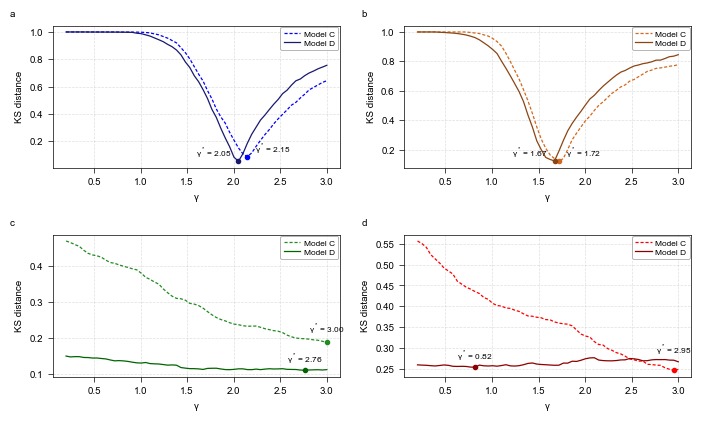

In [12]:
# ============================================================
#@title Supplementary Figure: SC & PE KS-distance Trace (γ-scan)
# [Final Refined: Text Positions & Offsets Optimized]
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt

# [가정: GAMMA_GRID, best_params, ks_traces 등은 이전 셀에서 정의됨]

print(">> Plotting Supplementary Figure (Final Position Tweak)...")

# 180mm = 7.08 inches
fig_width = 180 / 25.4
fig_height = 110 / 25.4
fig, axs = plt.subplots(2, 2, figsize=(fig_width, fig_height))

MAX_FONT = 7
LEGEND_FONT = 6

panels_ks = [
    (axs[0,0], "SC_nw", "a"),
    (axs[0,1], "SC_w",  "b"),
    (axs[1,0], "PE_nw", "c"),
    (axs[1,1], "PE_w",  "d")
]

for ax, key, p_label in panels_ks:
    ksC = ks_traces[key]["C"]
    ksD = ks_traces[key]["D"]
    theme = color_themes[key]

    # Trace 플롯
    ax.plot(GAMMA_GRID, ksC, lw=0.9, color=theme['C'], linestyle=(0, (2.5, 1.5)), label="Model C")
    ax.plot(GAMMA_GRID, ksD, lw=0.9, color=theme['D'], linestyle='-', label="Model D")

    # [핵심 수정] 텍스트 위치 최적화
    if np.any(np.isfinite(ksC)):
        iC = int(np.nanargmin(ksC))
        ax.plot(GAMMA_GRID[iC], ksC[iC], 'o', color=theme['C'], markersize=3)

        if 'SC' in key:
            text_pos = (GAMMA_GRID[iC] + 0.08, ksC[iC] + 0.005)
            ha, va = 'left', 'bottom'
        elif key == 'PE_w':
            # 패널 d: Model C는 더 위로 이동
            text_pos = (GAMMA_GRID[iC], ksC[iC] + 0.030)
            ha, va = 'center', 'bottom'
        else:
            # 패널 c: 기본 위치
            text_pos = (GAMMA_GRID[iC], ksC[iC] + 0.015)
            ha, va = 'center', 'bottom'

        ax.text(text_pos[0], text_pos[1], rf"$\gamma^*={GAMMA_GRID[iC]:.2f}$",
                fontsize=LEGEND_FONT, color='black', ha=ha, va=va)

    if np.any(np.isfinite(ksD)):
        iD = int(np.nanargmin(ksD))
        ax.plot(GAMMA_GRID[iD], ksD[iD], 'o', color=theme['D'], markersize=3)

        if 'SC' in key:
            text_pos = (GAMMA_GRID[iD] - 0.08, ksD[iD] + 0.005)
            ha, va = 'right', 'bottom'
        else:
            # [수정] 패널 c, d 공통: Model D 텍스트를 포인트에 더 가깝게 붙임 (0.005)
            text_pos = (GAMMA_GRID[iD], ksD[iD] + 0.010)
            ha, va = 'center', 'bottom'

        ax.text(text_pos[0], text_pos[1], rf"$\gamma^*={GAMMA_GRID[iD]:.2f}$",
                fontsize=LEGEND_FONT, color='black', ha=ha, va=va)

    # 축 서식
    ax.set_ylabel("KS distance", fontsize=MAX_FONT)
    ax.set_xlabel(r"$\gamma$", fontsize=MAX_FONT)
    ax.tick_params(axis='both', which='major', labelsize=MAX_FONT, width=0.5)
    ax.grid(True, linestyle='--', alpha=0.4, linewidth=0.5)
    for spine in ax.spines.values(): spine.set_linewidth(0.5)

    ax.text(-0.15, 1.05, p_label, transform=ax.transAxes, fontsize=MAX_FONT, fontweight='bold', va='bottom', ha='left')

    # 범례 서식
    legend = ax.legend(loc='upper right', fontsize=LEGEND_FONT, frameon=True,
                       labelspacing=0.25, handletextpad=0.4, borderaxespad=0.2)
    legend.get_frame().set_linewidth(0.5)
    legend.get_frame().set_edgecolor('#808080')

plt.tight_layout()

# 저장
PDF_DIR = "/content/drive/MyDrive/FMC_Data/Combined_Figure/"
os.makedirs(PDF_DIR, exist_ok=True)

save_path_pdf_ks = os.path.join(PDF_DIR, "Supp_Figure_KS_Trace_Final.pdf")
save_path_jpg_ks = os.path.join(PDF_DIR, "Supp_Figure_KS_Trace_Final.jpg")
plt.savefig(save_path_pdf_ks, bbox_inches="tight")
plt.savefig(save_path_jpg_ks, dpi=300, bbox_inches="tight")

print(f"\n>> [Saved] {save_path_pdf_ks}")
plt.show()